<a href="https://colab.research.google.com/github/syma-afsha/AI_LAB/blob/main/Copy_of_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Exam for Deep Network Development course. First part (mandatory)**

This notebook contains the task to be solved in order to pass the exam.
This is the first part of the exam, which is compolsury in order to get a grade. It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function.

Please note that, to **PASS** the Deep Network Development course you must **SUBMIT A SUCCESSFUL SOLUTION FOR THE FIRST PART**. If you **FAIL** the first part, you have the right to do the exam **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course. If you **PASS** the first part, then you get the weighted average of your quizzes and assignments as your final grade.

## Your information
Please fill the next cell with your information

**Full Name**:

**Neptun code:**

**Date:** 09/01/2024 9AM-10AM

## Task Description

#### Your task is to implement a custom architecture inspired by a image-to-image Diffusion like model, and the forward function. The model receives an intial image and a text as input (describes how the final image should look like) and generates an image according to the two.

#### Afterwards, make sure to run cell code number 1.2. to check if your implementation is correct.

#### This task should be **SOLVED IN 1 HOUR** and submitted to Canvas (download the .ipynb file). Please note that after 1 hour, the Canvas exam assignment will be closed and you cannot submit your solution.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### **NO GPU IS NEEDED for this task**. No training nor any computationally expensive operation will be performed. This notebook runs on any computer using a cpu.

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device

## 1. Architecture

#### Please keep in mind that this architecture is purely imagined and should not correspond to any existing model / architecture. You will not find it on the internet.

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/11gey3SssCJe6CIUiFON9e-eoLdkegDna/view?usp=drive_link

<br>
<br>

![](https://drive.google.com/uc?export=view&id=11gey3SssCJe6CIUiFON9e-eoLdkegDna)

#### Input image

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((256, 256))
image = np.rollaxis(np.array(image), 2, 0)

In [ ]:
image.shape

(3, 256, 256)

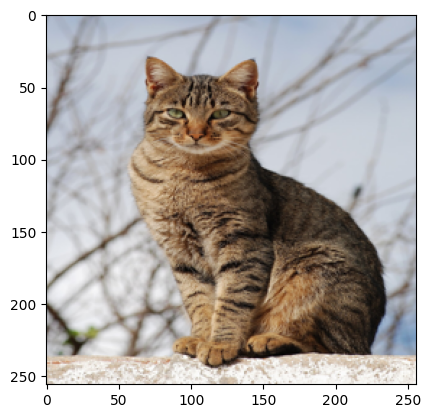

In [ ]:
plt.imshow(np.moveaxis(image, 0,-1))

In [ ]:
#Simple pre-processing
input_image = torch.tensor(image,dtype=torch.float32)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

torch.Size([1, 3, 256, 256])

#### Input text

In [ ]:
text = "A cat wearing sunglasses and suit"

# Simple preprocessing the text
word_to_ix = {"A": 0, "cat": 1, "wearing": 2, "sunglasses": 3, "and": 4, "suit": 5}
lookup_tensor = torch.tensor(list(word_to_ix.values()), dtype=torch.long) # a tensor representing words by integers

vocab_size = len(lookup_tensor)

In [ ]:
vocab_size

6

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageEncoder, self).__init__()
        # DEFINE the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2)
        self.batchnorm= nn.BatchNorm2d(64)
        self.relu=nn.ReLU()

    def forward(self, input_image):
        # SEND the input image and then the features to the given layers
        print(f"Input image: {input_image.size()}")
        x = self.conv1(input_image)
        print(f"After conv1: {x.size()}")
        x = self.relu(x)
        x = self.conv2(x)
        print(f"After conv2: {x.size()}")
        x = self.relu(x)
        x=self.batchnorm(x)
        print(f"After batchnorm: {x.size()}")

        return x

image_encoder=ImageEncoder(3,64)
img_enc=image_encoder(input_image)

Input image: torch.Size([1, 3, 256, 256])
After conv1: torch.Size([1, 64, 256, 256])
After conv2: torch.Size([1, 64, 128, 128])
After batchnorm: torch.Size([1, 64, 128, 128])


#### 1.1. Implement the architecture

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channels):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=1024)
        self.convtrans1 = nn.ConvTranspose2d(in_channels=6, out_channels=32, kernel_size=4, stride=4, padding=0) #change kernel

        # DEFINE the layers

    def forward(self, input_text):
        # EMBED the input text
        x = self.embedding(input_text)
        print(f"After embedding: {x.size()}")
        # RESHAPE the embeddings
        x=x.unsqueeze(0).unsqueeze(0)
        print(f"After reshaping: {x.size()}")
        x=x.view(1,6,32,32)
        print(f"After reshaping: {x.size()}")
        x=self.convtrans1(x)
        print(f"After convtrans1: {x.size()}")



        # RESHAPE the embeddings and SEND them to the next layer

        return x
text_encoder=TextEncoder(vocab_size,1024,6)
txt_enc=text_encoder(lookup_tensor)

After embedding: torch.Size([6, 1024])
After reshaping: torch.Size([1, 1, 6, 1024])
After reshaping: torch.Size([1, 6, 32, 32])
After convtrans1: torch.Size([1, 32, 128, 128])


In [ ]:
torch.cat((img_enc,txt_enc),dim=1).shape

torch.Size([1, 96, 128, 128])

In [ ]:
class MyUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyUNet, self).__init__()
        # DEFINE the layers
        self.conv1 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, padding="same")
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same")
        self.conv3=nn.Conv2d(in_channels=256, out_channels=64, kernel_size=2, padding="same")
        self.convtrans1=nn.ConvTranspose2d(in_channels=320, out_channels=128, kernel_size=4, stride=2, padding=1) #change kernel
        self.conv4=nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding="same")

    def forward(self, combined_features):
        # SEND the combined features to the given layers of the downscaling part of the U-Net
        x1= self.conv1(combined_features)
        print(f"After conv1: {x1.size()}")
        x1=self.relu(x1)
        print(f"After ReLU: {x1.size()}")
        x=self.pool(x1)
        print(f"After pooling: {x.size()}")
        x=self.conv2(x)
        print(f"After conv2: {x.size()}")
        x=self.relu(x)
        x2=self.conv3(x)
        print(f"After conv3: {x2.size()}")
        x2=self.relu(x2)
        x=torch.cat((x,x2),dim=1)
        print(f"After concatenation: {x.size()}")
        x=self.convtrans1(x)
        print(f"After convtrans1: {x.size()}")
        x=torch.concat((x1,x),dim=1)
        print(f"After concatenation: {x.size()}")
        x=self.conv4(x)
        print(f"After conv4: {x.size()}")
        x=self.relu(x)





        # COMBINE the features before you send them to the ConvTranspose2d layer of the U-Net

        # SEND the COMBINED features to the ConvTranspose2d layer

        # COMBINE the features again before you send them to the last Conv2d layer of the U-Net

        # SEND the COMBINED features to the last Conv2d and ReLU layer of the U-Net

        return x
combined_features=torch.cat((img_enc,txt_enc),dim=1)
Unet=MyUNet(96,128)
unet=Unet(combined_features)

After conv1: torch.Size([1, 128, 128, 128])
After ReLU: torch.Size([1, 128, 128, 128])
After pooling: torch.Size([1, 128, 64, 64])
After conv2: torch.Size([1, 256, 64, 64])
After conv3: torch.Size([1, 64, 64, 64])
After concatenation: torch.Size([1, 320, 64, 64])
After convtrans1: torch.Size([1, 128, 128, 128])
After concatenation: torch.Size([1, 256, 128, 128])
After conv4: torch.Size([1, 64, 128, 128])


/home/syma/Python-3.10.0/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


In [ ]:
class ImageDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageDecoder, self).__init__()
        # DEFINE the layers
        self.convtrans=nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
        self.batchnorm=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()

    def forward(self, image_features):
        # SEND the image features to the given layers
        x=self.batchnorm(image_features)
        print(f"After batchnorm: {x.size()}")
        x=self.convtrans(x)
        print(f"After convtrans: {x.size()}")
        x=self.relu(x)


        return x
decoder=ImageDecoder(64,3)
img_decoder=decoder(unet)

After batchnorm: torch.Size([1, 64, 128, 128])
After convtrans: torch.Size([1, 3, 256, 256])


In [ ]:
class ImageToImageGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels):
        super(ImageToImageGenerator, self).__init__()
        # DEFINE the TEXT ENCODER, IMAGE ENCODER, U-NET, and IMAGE DECODER
        self.img_encoder=ImageEncoder(image_channels,image_encoder_out_channels)

        self.txt_encoder=TextEncoder(vocab_size,embedding_dim,text_encoder_out_channels)
        self.unet=MyUNet(text_encoder_out_channels+image_encoder_out_channels,unet_out_channels)
        self.img_decoder=ImageDecoder(unet_out_channels,image_channels)

    def forward(self, input_text, input_image):
        # SEND the input text to the TEXT ENCODER
        txt_enc=self.txt_encoder(input_text)

        # SEND the input image to the IMAGE ENCODER
        img_enc=self.img_encoder(input_image)

        # COMBINE the TEXT FEATURES form the TEXT ENCODER and IMAGE FETURES from the IMAGE ENCODER
        combined_features=torch.cat((img_enc,txt_enc),dim=1)

        # SEND the COMBINED FETURES to the U-NET
        unet=self.unet(combined_features)

        # SEND the IMAGE FETURES from the U-NET to the IMAGE DECODER
        generated_image=self.img_decoder(unet)

        return generated_image

In [ ]:
embedding_dim = 1024
image_channels = 3
text_encoder_out_channels = 32
image_encoder_out_channels = 64
unet_out_channels = 64
model = ImageToImageGenerator(vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels)

input_text = lookup_tensor

# Forward pass
output = model(input_text, input_image)
print('----------------------------------------------------------------')
print("Output Image Shape:", output.shape)

After embedding: torch.Size([6, 1024])
After reshaping: torch.Size([1, 1, 6, 1024])
After reshaping: torch.Size([1, 6, 32, 32])
After convtrans1: torch.Size([1, 32, 128, 128])
Input image: torch.Size([1, 3, 256, 256])
After conv1: torch.Size([1, 64, 256, 256])
After conv2: torch.Size([1, 64, 128, 128])
After batchnorm: torch.Size([1, 64, 128, 128])
After conv1: torch.Size([1, 128, 128, 128])
After ReLU: torch.Size([1, 128, 128, 128])
After pooling: torch.Size([1, 128, 64, 64])
After conv2: torch.Size([1, 256, 64, 64])
After conv3: torch.Size([1, 64, 64, 64])
After concatenation: torch.Size([1, 320, 64, 64])
After convtrans1: torch.Size([1, 128, 128, 128])
After concatenation: torch.Size([1, 256, 128, 128])
After conv4: torch.Size([1, 64, 128, 128])
After batchnorm: torch.Size([1, 64, 128, 128])
After convtrans: torch.Size([1, 3, 256, 256])
----------------------------------------------------------------
Output Image Shape: torch.Size([1, 3, 256, 256])


#### 1.2. Test your implementation
Expected output

torch.Size( [1, 3, 256, 256] )

For fun -- check the generated image, it should look something like this: https://drive.google.com/file/d/1qCCmxt5FKdOrGrFkajti9_UFvZAPaSHA/view?usp=sharing

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1qCCmxt5FKdOrGrFkajti9_UFvZAPaSHA)


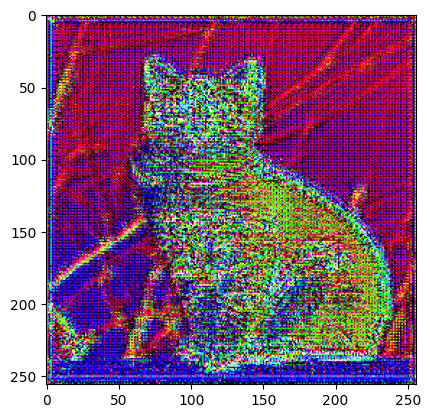

In [ ]:
%matplotlib inline

rgb_array = output[0].permute(1, 2, 0).detach().numpy()
rgb_array = rgb_array.clip(0, 1)
plt.imshow(rgb_array)